In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math

%matplotlib inline

In [10]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    return lines
  
def hough_img(img, lines):    
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def line_coeffs(line):
    c1 = (line[3]-line[1])/(line[2]-line[0]) # slope
    c0 = line[1] - c1 * line[0]
    return c0, c1

def extrapolate_left_right(lines):

    # The better approach is to represent the lines using y = mx + c. 
    # Similar lines will have similar m and c. 
    # Then you find the average of two lines by averaging m and c.
    
    right_lines = []
    left_lines = []

    for line in lines:
        c0, c1 = line_coeffs(line[0]) # c1 == slope
        if c1 > 0:
            right_lines.append((c0,c1))
        else:
            left_lines.append((c0,c1))

    ravg = np.mean(right_lines, axis=0)
    lavg = np.mean(left_lines, axis=0)

    #print('Left:')
    #print(left_lines)
    #print('Right: ')
    #print(right_lines)

    # add left and right line
    # take the start point of the closest line and the end point of the line far away

    result = []
    result.append(left_lines[0])
    result[0][0][2] = left_lines[len(left_lines)-1][0][2]
    result[0][0][3] = left_lines[len(left_lines)-1][0][3]
    result.append(right_lines[0])
    result[1][0][0] = right_lines[len(right_lines)-1][0][0]
    result[1][0][1] = right_lines[len(right_lines)-1][0][1]

    # calculate slopes and extend lines to same y on both ends

    return result

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


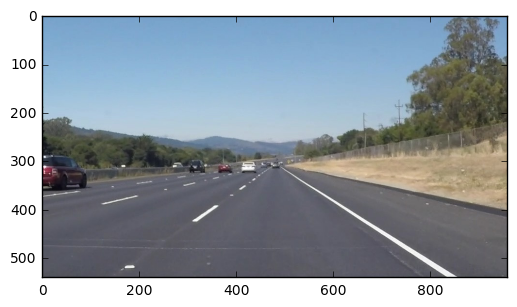

In [50]:
# Read in and grayscale the image
# Note: in the previous example we were reading a .jpg 
# Here we read a .png and convert to 0,255 bytescale
#image = (mpimg.imread('exit_ramp.png')*255).astype('uint8')
#gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

image = mpimg.imread('test_images/solidWhiteRight.jpg')
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image);

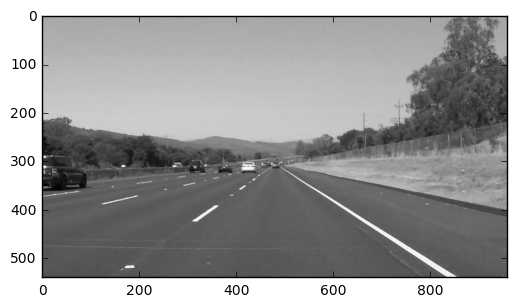

In [51]:
gray = grayscale(image)
plt.imshow(gray, cmap='gray');

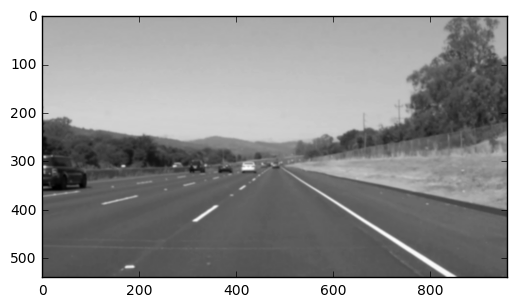

In [52]:
# Define a kernel size and apply Gaussian smoothing
# The goal of using Gaussian Blur (or any other blurring method) is to reduce the noise 
# (dots, or small edges in the image that are not actually edges), and thus,
# avoid detecting unwanted edges.
kernel_size = 7
blur_gray = gaussian_blur(gray, kernel_size)
plt.imshow(blur_gray, cmap='gray');

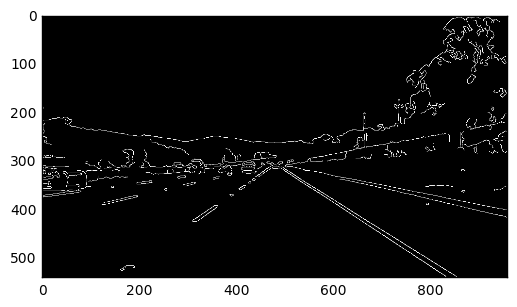

In [53]:
# Define our parameters for Canny and apply
low_threshold = 30
high_threshold = 90
edges = canny(blur_gray, low_threshold, high_threshold)

plt.imshow(edges, cmap='gray');

Right slope:  0.4634146341463415
Left slope:  -0.5


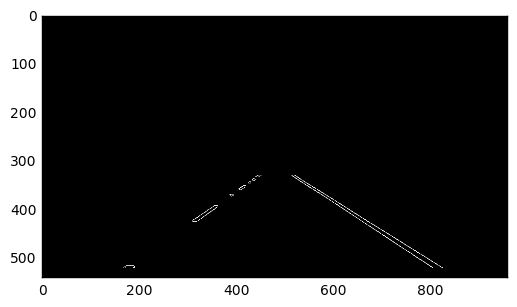

In [62]:
# A four sided polygon to mask

imshape = image.shape
left_bottom = (50, imshape[0]-20)
left_top = (430, 330)
right_bottom = (imshape[1], imshape[0]-20)
right_top = (550, 330)

vertices = np.array([[left_bottom, left_top, right_top, right_bottom]], dtype=np.int32)

masked_edges = region_of_interest(edges, vertices)

right_slope = (right_bottom[1]-right_top[1])/(right_bottom[0]-right_top[0])
left_slope = (left_bottom[1]-left_top[1])/(left_bottom[0]-left_top[0])
print('Right slope: ', right_slope)
print('Left slope: ', left_slope)

plt.imshow(masked_edges, cmap='gray');

[[[545 350 650 418]]

 [[521 330 559 355]]

 [[614 388 640 406]]

 [[753 486 777 503]]

 [[321 424 362 394]]

 [[313 421 353 394]]

 [[679 437 715 462]]

 [[672 425 716 453]]

 [[585 370 620 393]]

 [[659 417 675 428]]

 [[711 449 740 468]]

 [[645 416 659 424]]

 [[788 510 796 514]]

 [[727 470 735 474]]

 [[754 476 767 485]]

 [[405 357 416 351]]

 [[349 396 355 392]]

 [[740 467 752 476]]

 [[173 516 189 516]]

 [[812 512 818 516]]

 [[739 478 751 485]]

 [[518 332 545 351]]

 [[318 425 343 407]]

 [[772 488 780 492]]

 [[779 504 784 506]]

 [[798 503 805 508]]

 [[785 496 793 500]]

 [[673 433 680 439]]

 [[702 452 710 458]]

 [[631 399 638 404]]

 [[321 415 348 397]]

 [[733 474 738 476]]

 [[794 514 799 516]]

 [[716 462 726 468]]

 [[808 510 817 516]]

 [[542 348 547 352]]

 [[595 377 601 381]]

 [[557 353 562 356]]

 [[582 369 589 373]]

 [[572 368 578 372]]

 [[732 462 738 466]]

 [[528 340 534 344]]

 [[789 510 795 514]]]


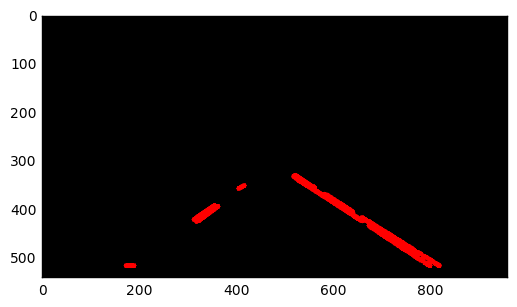

In [66]:
# Define the Hough transform parameters
rho = 2 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 5     # minimum number of votes (intersections in Hough grid cell)
min_line_len = 5 #minimum number of pixels making up a line
max_line_gap = 1  # maximum gap in pixels between connectable line segments
lines = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)
# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
#lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
#                            min_line_length, max_line_gap)
line_image = hough_img(masked_edges, lines)
print(lines)
plt.imshow(line_image);

In [56]:
right_lines = []
left_lines = []

for line in lines:
        #c1 = (line[0][3]-line[0][1])/(line[0][2]-line[0][0]) # slope
        #c0 = line[0][1] - c1 * line[0][0]
        c0, c1 = line_coeffs(line[0])
        if c1 > 0:
            print(line[0])
            right_lines.append((c0,c1))
        else:
            left_lines.append((c0,c1))
            
ravg = np.mean(right_lines, axis=0)
lavg = np.mean(left_lines, axis=0)

# now calculate end points for left and right line segments
# these have 
left_line = np.array([[(left_bottom[1]-lavg[0])/lavg[1],left_bottom[1],(left_top[1]-lavg[0])/lavg[1],left_top[1]]], dtype=np.int32)
right_line = np.array([[(right_bottom[1]-ravg[0])/ravg[1],right_bottom[1],(right_top[1]-ravg[0])/ravg[1],right_top[1]]], dtype=np.int32)

print(left_line, right_line)

[520 330 853 538]
[651 420 832 538]
[515 331 577 370]
[575 370 629 404]
[656 416 664 421]
[639 412 665 428]
[666 422 677 429]
[508 322 529 335]
[757 479 762 482]
[509 326 515 330]
[501 322 511 328]
[809 524 831 538]
[629 405 645 415]
[555 357 597 383]
[[146 540 484 322]] [[848 540 500 322]]


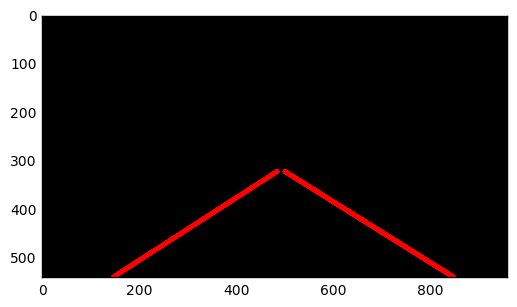

In [57]:
#lines = extrapolate_left_right(lines, bottom, top)
#lines = extrapolate_left_right(lines)
#line_image = hough_img(masked_edges, lines)
line_image = hough_img(masked_edges, [left_line, right_line])
# Iterate over the output "lines" and draw lines on a blank image
#for line in lines:
#    for x1,y1,x2,y2 in line:
#        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)

plt.imshow(line_image);

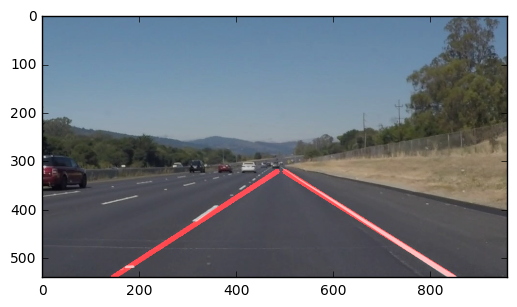

In [58]:
# Create a "color" binary image to combine with line image
#color_edges = np.dstack((edges, edges, edges)) # Draw the lines on the edge image
#lines_edges = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0) 
#lines_edges = cv2.addWeighted(image, 0.8, line_image, 1, 0) 
lines_edges = weighted_img(line_image, image)
plt.imshow(lines_edges);

In [59]:
def find_lane_lines(img):
    gray = grayscale(img)
    kernel_size = 7
    blur_gray = gaussian_blur(gray, kernel_size)
    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold)
    
    imshape = image.shape
    vertices = np.array([[(100,imshape[0]),(450, 322), (520, 322), (imshape[1]-20,imshape[0])]], dtype=np.int32)
    #vertices = np.array([[(120,imshape[0]),(460, 318), (500, 318), (imshape[1]-20,imshape[0])]], dtype=np.int32)
    #vertices = np.array([[(0,imshape[0]),(475, 310), (480, 310), (imshape[1],imshape[0])]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)
    
    # Define the Hough transform parameters
    rho = 2           # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 15    # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 5  # minimum number of pixels making up a line
    max_line_gap = 1  # maximum gap in pixels between connectable line segments
    lines = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)
    lines = extrapolate_left_right(lines)
    line_image = hough_img(masked_edges, lines)
    
    lines_edges = weighted_img(line_image, image)
    
    return lines_edges

In [60]:
lines_img = find_lane_lines(image)
plt.imshow(lines_img, cmap='gray');

IndexError: invalid index to scalar variable.